# Building a good model

## Candidate algorithms: 

### 1. logistic regression
- This is suitable for binary classification and is the litmus test for testing data's linearity, which I am not sure of.
- I will drop some features with missing data points.

### 2. Random forests
- Random forest classification can deal well with categorical data such as the `PRODUCT´ feature. 
- It will also not require any One-Hot-Encoding, and adding that would actually introduce sparsity we don't want.
- This is also a good candidate for improving recall in imbalanced classes.


In [1]:
%pip install pandas
%pip install numpy
%pip install seaborn

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA # dimension reduction

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans # experimineting

from sklearn.preprocessing import StandardScaler #scaling

from sklearn.pipeline import Pipeline # training pipeline
from sklearn.ensemble import RandomForestClassifier #1
from sklearn.linear_model import LogisticRegression #2
from sklearn.model_selection import GridSearchCV # optimization

# reporting results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report
from sklearn.model_selection import cross_val_score


# import seaborn as sns


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [3]:
dataset = pd.read_csv('../problem/churn_data.csv')

## Data Cleaning / Preprocessing

In [5]:
dataset.isnull().any()

ID                          False
PRODUCT                     False
CHURN_FLAG                  False
TENURE                      False
AVG_PLAY_120                False
AVG_PLAY_90                  True
SERIES_AVG_PLAY_LAST_120    False
SERIES_AVG_PLAY_LAST_90      True
FILM_AVG_PLAY_LAST_120      False
FILM_AVG_PLAY_LAST_90        True
dtype: bool

In [7]:
 # separating the label from the data
df_CHURN_LABEL = dataset.CHURN_FLAG

# As disucssed in the data_exploration.ipynb, all *_90 features are dropped.
 
df_DATA = dataset[['PRODUCT', 'TENURE', 'AVG_PLAY_120', 'SERIES_AVG_PLAY_LAST_120', 'FILM_AVG_PLAY_LAST_120']] # data to include in training with dropped columns
df_DATA_no_NaN = df_DATA.fillna(df_DATA.mean())

# checking that everything went alright
print("DF Shapes")
print(df_CHURN_LABEL.shape)
print(df_DATA.shape)

# Adding one hot encoding since the product is a categorical feature
one_hot_encoded_DATA = pd.get_dummies(df_DATA_no_NaN,prefix=['PRODUCT'], columns=['PRODUCT'])

# making the data into ndarrays
X, Y = np.array(df_DATA_no_NaN), np.array(df_CHURN_LABEL) 
X_OHE, Y_OHE = np.array(one_hot_encoded_DATA), np.array(df_CHURN_LABEL)

# splitting the training and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True) # without one hot encoding
X_train_OHE, X_test_OHE, y_train_OHE, y_test_OHE =  train_test_split(X_OHE, Y_OHE, test_size=0.25, shuffle=True) # with one hot encoding


DF Shapes
(39121,)
(39121, 5)


## 1. Logistic Regression

In [8]:
pca = PCA()
logistic = LogisticRegression(max_iter=10000, tol=1e-4, penalty='l2')
pipe = Pipeline(steps=[('pca', pca), ('standardscaler', StandardScaler()), ('logistic', logistic)])
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train_OHE, y_train_OHE)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

y_pred = search.predict(X_test_OHE)
print(classification_report(y_test_OHE, y_pred))


Best parameter (CV score=0.884):
{'logistic__C': 0.0001, 'pca__n_components': 5}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1135
           1       0.88      1.00      0.94      8646

    accuracy                           0.88      9781
   macro avg       0.44      0.50      0.47      9781
weighted avg       0.78      0.88      0.83      9781



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### We can see from above that this is a bad choice. Given that the majority of our rows have a `CHURN_FLAG` label of `1`, it's entirely possible to get a relatively high accuracy from the first try (such as `89%`) but with a very small macro f1-score (of `44%`).

#### This is a sign of over-fitting, despite having removed redundant features, performed one hot encoding, and added L2 regularization.

#### This model should therefore be eliminated.

## 2. Random Forests

In [12]:
def rfc(X_train_set, y_train_set, X_test_set, y_test_set, max_depth=40, random_state=0, min_samples_leaf = 3, min_samples_split = 4, n_estimators = 200, criterion='gini', max_features='auto', class_weight=None):
    random_forest = RandomForestClassifier(max_depth=max_depth, random_state=random_state, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators, criterion=criterion, max_features=max_features, class_weight=class_weight)
    model = random_forest.fit(X_train_set, y_train_set.ravel())

    y_pred = model.score(X_test_set, y_test_set)

    acc_model = round(model.score(X_test_set, y_test_set) * 100, 2)
    print("Model Accuracy:", round(acc_model,2,), "%")
    y_pred = model.predict(X_test_set)
    print(classification_report(y_test_set, y_pred))
    return model

#### Using the scikit-learn Random Forest classifier already gives us better results, as seen below:

#### However, it is clear that recall for `CHURN_FLAG`=`0` needs to be improved in both precision and recall.

In [13]:
# scaling data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.fit_transform(X_test, y_test)

rfc_scaled = rfc(X_train_scaled, y_train, X_test_scaled, y_test)


Model Accuracy: 80.84 %
              precision    recall  f1-score   support

           0       0.29      0.46      0.35      1114
           1       0.92      0.85      0.89      8667

    accuracy                           0.81      9781
   macro avg       0.61      0.66      0.62      9781
weighted avg       0.85      0.81      0.83      9781



#### After taking a quick look at the most important features for this random forest classifier, we find that the `PRODUCT` feature has the lowest importance score of all.


<AxesSubplot:xlabel='feature'>

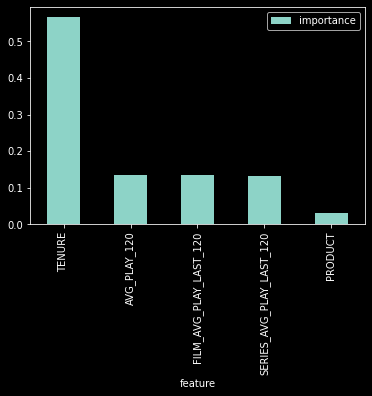

In [14]:
importances = pd.DataFrame({'feature':df_DATA.columns,'importance':np.round(rfc_scaled.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)
importances[:15].plot.bar()

#### One option to impvoe recall could be to remove the `PRODUCT` feature. It did (from `48%` to `53%`); but, as shown below, there was quite a decrease in precision. Our macro-averaged F1-score has also dropped.

In [15]:
# Random forest classifier with product removed
rfc_scaled_no_product = rfc(X_train_scaled[:, 1:], y_train, X_test_scaled[:, 1:], y_test)

Model Accuracy: 68.61 %
              precision    recall  f1-score   support

           0       0.18      0.51      0.27      1114
           1       0.92      0.71      0.80      8667

    accuracy                           0.69      9781
   macro avg       0.55      0.61      0.54      9781
weighted avg       0.83      0.69      0.74      9781



#### Another way to improve the score would be to use the One Hot Encoded `PRODUCT` feature. 

### This seems to significantly improve precision while creating a drop in recall, though both are more balanced now.
### The overall accuracy and macro f1-scores are higher.

In [17]:
X_train_OHE_scaled = scaler.fit_transform(X_train_OHE, y_train)
X_test_OHE_scaled = scaler.fit_transform(X_test_OHE, y_test)

rfc_scaled_no_product_OHE = rfc(X_train_OHE_scaled, y_train_OHE, X_test_OHE_scaled, y_test_OHE)

Model Accuracy: 86.19 %
              precision    recall  f1-score   support

           0       0.41      0.43      0.42      1135
           1       0.92      0.92      0.92      8646

    accuracy                           0.86      9781
   macro avg       0.67      0.67      0.67      9781
weighted avg       0.86      0.86      0.86      9781



#### With the latest changes, training the model on a scaled one-hot-encoded dataset has yielded significantly higher precision, but recall remains a problem. This is mainly due to the class imbalance problem.

#### To counter this, `sklearn.ensemble.RandomForestClassifier` offers a `class_weight` parameter that associates different weights to different labels. In our case, `CHURN_FLAG=0` is underrepresented.

#### We can achieve better results by increasing its weight proportional to `CHURN_FLAG=1`

In [19]:
X_test_OHE_scaled = scaler.fit_transform(X_test_OHE, y_test_OHE)

rfc_scaled_no_product_OHE_weighted = rfc(X_train_OHE_scaled, y_train_OHE, X_test_OHE_scaled, y_test_OHE, class_weight={0: 2.5, 1: 0.9})


Model Accuracy: 84.92 %
              precision    recall  f1-score   support

           0       0.38      0.45      0.41      1135
           1       0.93      0.90      0.91      8646

    accuracy                           0.85      9781
   macro avg       0.65      0.68      0.66      9781
weighted avg       0.86      0.85      0.86      9781



#### To find the absolute best model we could get, we can create a grid parameter dictionary focusing on the main hyperparameters.

In [23]:

grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'class_weight': [{0: 2, 1: 1}, {0: 2.5, 1: 0.9}, {0: 3, 1: 1}, {0: 4, 1: 1}, {0: 5, 1: 1}],
    'max_depth': [20, 30, 40, 50, 60]
}

random_forest = RandomForestClassifier(random_state=0, min_samples_leaf = 3, min_samples_split = 4)

gd_sr = GridSearchCV(estimator=random_forest,
                     param_grid=grid_param,
                     scoring={'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'f1_macro': make_scorer(f1_score)},
                     refit='f1_macro',
                     cv=5,
                     n_jobs=-1)

In [27]:
#!# Takes approx. 40 minutes to run

gd_sr.fit(X_train_OHE_scaled, y_train_OHE)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(min_samples_leaf=3,
                                              min_samples_split=4,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 2, 1: 1}, {0: 2.5, 1: 0.9},
                                          {0: 3, 1: 1}, {0: 4, 1: 1},
                                          {0: 5, 1: 1}],
                         'max_depth': [20, 30, 40, 50, 60],
                         'n_estimators': [100, 300, 500, 800, 1000]},
             refit='f1_macro',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_macro': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [69]:
print(gd_sr.best_estimator_) 
print(gd_sr.best_params_) # {'class_weight': {0: 2, 1: 1}, 'max_depth': 20, 'n_estimators': 500}
print(gd_sr.best_score_) 

RandomForestClassifier(class_weight={0: 2, 1: 1}, max_depth=20,
                       min_samples_leaf=3, min_samples_split=4,
                       n_estimators=500, random_state=0)
{'class_weight': {0: 2, 1: 1}, 'max_depth': 20, 'n_estimators': 500}
0.954308926416577


In [29]:
# training the best model decided by GridSearchCV
best_random_forest = RandomForestClassifier(random_state=0, min_samples_leaf = 3, min_samples_split = 4, class_weight={0: 2, 1: 1}, max_depth=20, n_estimators=500)
best_model = best_random_forest.fit(X_train_OHE_scaled, y_train_OHE.ravel())

y_pred = best_model.score(X_test_OHE_scaled, y_test_OHE)

acc_model = round(best_model.score(X_test_OHE_scaled, y_test_OHE) * 100, 2)
print("Model Accuracy:", round(acc_model,2,), "%")
y_pred = best_model.predict(X_test_OHE_scaled)
print(classification_report(y_test_OHE, y_pred))


Model Accuracy: 85.51 %
              precision    recall  f1-score   support

           0       0.39      0.44      0.41      1135
           1       0.93      0.91      0.92      8646

    accuracy                           0.86      9781
   macro avg       0.66      0.67      0.67      9781
weighted avg       0.86      0.86      0.86      9781



In [71]:
# our cross-validation score is much higher, but is also trained on a bigger amount of data

X_OHE_scaled = scaler.fit_transform(X_OHE, Y_OHE)

best_random_forest_cv = RandomForestClassifier(random_state=0, min_samples_leaf = 3, min_samples_split = 4, class_weight={0: 2, 1: 1}, max_depth=40, n_estimators=800)
all_accuracies = np.mean(cross_val_score(estimator=best_random_forest_cv, X=X_OHE, y=Y_OHE, cv=10))
print(round(all_accuracies,2,)*100, "%")

92.0 %


## Is this model ready for production? It depends. 

### Precision and recall are very high for users who will churn. We would need to evaluate the cost of taking action to reduce churn with users who may have been false positives. If catching the biggest amount of churning users is what we are interested in, then we may not need to train the model further. 

### If, however, action is to be taken with non-churning users (to try to keep them for longer, etc), then we would need to reduce the class imbalance in the model and re-train it or choose another option altogether (such as a neural network, and so on). If the end-goal requires being able to accurately capture majority of users who will not churn (`CHURN_FLAG=0`), then we would aim to increase recall for that class. 
